In [460]:
# ! pip install opencv-python
# ! pip install pysteps
# ! pip install cartopy
# ! pip install pyproj
# ! pip install pygrib

In [461]:
import os
from pathlib import Path
import time
from typing import Any, Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from livelossplot import PlotLosses
from matplotlib.colors import ListedColormap
from scipy import io
from torch.utils.data import DataLoader
from tqdm import tqdm

from rainnow.src.conv_lstm_utils import (
    IMERGDataset,
    plot_predicted_sequence,
    save_checkpoint,
    train,
    validate,
    create_eval_loader,
)
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config
from rainnow.src.utilities.utils import (
    get_device,
    transform_0_1_to_minus1_1,
    transform_minus1_1_to_0_1,
)
from rainnow.src.plotting import plot_a_sequence

from pysteps.utils import transformation
from pysteps import motion
from pysteps.visualization import plot_precip_field, quiver
from pysteps import nowcasts

In [462]:
# ** plotting helpers **
# cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
cmap = io.loadmat("/teamspace/studios/this_studio/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
global_params = {"font.size": 8}  # , "font.family": "Times New Roman"}
plt_params = {"wspace": 0.1, "hspace": 0.15}
ylabel_params = {"ha": "right", "va": "bottom", "labelpad": 1, "fontsize": 7.5}

# ** get device **
device = get_device()

Cuda installed! Running on GPU! (device = cuda)


In [463]:
# ** DIR helpers **
# CKPT_BASE_PATH = "/Users/ds423/git_uni/DYffcast/rainnow/results/"
# CONFIGS_BASE_PATH = "/Users/ds423/git_uni/DYffcast/rainnow/src/dyffusion/configs/"
CKPT_BASE_PATH = "/teamspace/studios/this_studio/DYffcast/rainnow/results/"
CONFIGS_BASE_PATH = "/teamspace/studios/this_studio/DYffcast/rainnow/src/dyffusion/configs/"

CKPT_DIR = "checkpoints"
CKPT_CFG_NAME = "hparams.yaml"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"
# whether or not to get last.ckpt or to get the "best model" ckpt (the other one in the folder).
GET_LAST = False

# ** Dataset Params **
REVERSE_PROBABILITY = 0.1

# ** Dataloader Params **
BATCH_SIZE = 24
NUM_WORKERS = 0

INPUT_SEQUENCE_LENGTH = 4
OUTPUT_SEQUENCE_LENGTH = 1

In [464]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        "boxes": ["1,0"],
        # "boxes": ["0,0", "1,0", "2,0", "2,1"],
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
        "normalization": None,  # set normalisation to None. Need raw mm/h for the STEPS nowcast.
)

In [465]:
# only need prior images for PySteps, no training required.
datamodule.setup("predict")

predict_dataset = IMERGDataset(
    datamodule, "predict", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)
predict_loader = DataLoader(
    dataset=predict_dataset, batch_size=6, num_workers=NUM_WORKERS, shuffle=False
)

[2024-11-24 15:35:33][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-11-24 15:35:33][imerg_precipitation.py][INFO] --> predict data split: [202303080000, 202303100000]
[2024-11-24 15:35:35][torch_datasets.py][INFO] --> creating PREDICT tensor dataset.
[2024-11-24 15:35:35][abstract_datamodule.py][INFO] -->  Dataset predict size: 11


In [466]:
# test train dataset.
X_dummy, y_dummy = predict_dataset.__getitem__(0)
print(X_dummy.size(), y_dummy.size())

assert X_dummy.size() == torch.Size([INPUT_SEQUENCE_LENGTH, 1, 128, 128])
assert y_dummy.size() == torch.Size([1, 1, 128, 128])

torch.Size([4, 1, 128, 128]) torch.Size([1, 1, 128, 128])


torch.Size([6, 4, 1, 128, 128]) torch.Size([6, 1, 1, 128, 128])


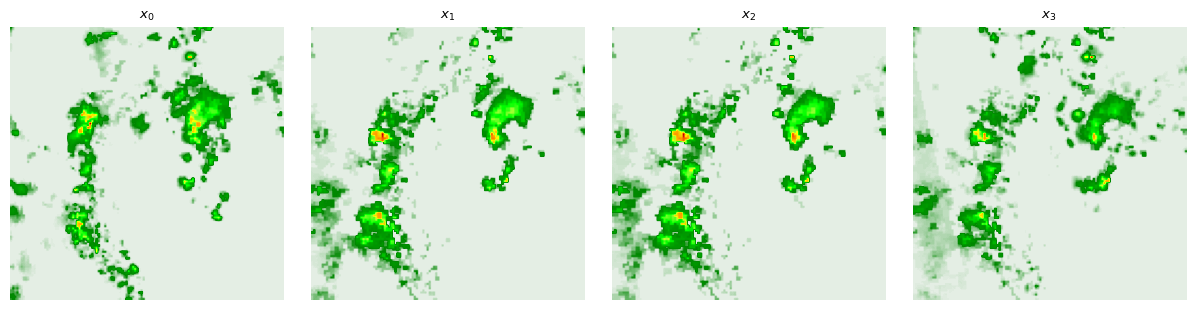

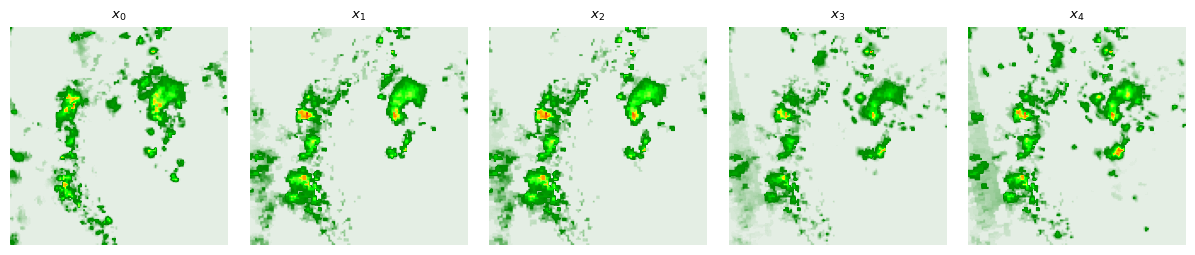

In [467]:
# plot a batch.
dummy_batch = next(iter(predict_loader))
dummy_inputs, dummy_target = dummy_batch
print(dummy_inputs.size(), dummy_target.size())

plot_a_sequence(
    X=dummy_inputs,
    b=0,
    global_params=global_params,
    plot_params={"cmap": rain_cmap},
    layout_params=plt_params,
)

# inputs & target
plot_a_sequence(
    X=torch.cat([dummy_inputs[b, ...], dummy_target[b, ...]], dim=0).unsqueeze(0),
    b=0,
    global_params=global_params,
    plot_params={"cmap": rain_cmap},
    layout_params=plt_params,
)

### `STEPS` in `PySteps`

In [483]:
from typing import Union, List, Tuple
import numpy as np
import torch
from pysteps.motion.lucaskanade import dense_lucaskanade


class PyStepsNowcastModel:
    """STEPS Probabilistic Nowcast Model wrapper for precipitation forecasting.

    Handles precipitation data in (S, C, H, W) format and produces ensemble nowcasts
    using the PySTEPS library implementation of STEPS.

    Note: following https://pysteps.readthedocs.io/en/stable/auto_examples/plot_steps_nowcast.html.
    """

    def __init__(
        self,
        input_precip_sequence: Union[np.ndarray, torch.Tensor, List],
        input_dims: Tuple[int, int, int] = (1, 128, 128),  # (C, H, W).
        horizon: int = 30,  # minutes.
        data_time_interval: int = 30,  # minutes.
        data_km_per_pixel_resolution: float = 10,
        num_ensemble: int = 1,
        transform_mm_h_to_dBR: bool = True,
    ):
        """Initialisation."""

        self.data = input_precip_sequence
        self.C, self.H, self.W = input_dims
        self.horizon = horizon
        self.time_interval = data_time_interval
        self.km_per_pixel = data_km_per_pixel_resolution
        self.n_ens_members = num_ensemble
        self.transform_mm_h_to_dBR = transform_mm_h_to_dBR

        # checks.
        self.convert_inputs_to_numpy()
        self.check_input_dims()
        self._validate_data()
        self._validate_params()

        # motion field using LK (lucas-kanade) method.
        self.motion_field = motion.get_method("lucaskanade")

        self.V = None
        # nowcast method.
        self.nowcast_method = nowcasts.get_method("steps")

    @staticmethod
    def num_timesteps_to_nowcast(horizon, time_interval):
        """"""
        assert (
            horizon % time_interval == 0
        ), f"Prediction horizon is not a multiple of the data freq (min) {self.time_interval}."
        return int(horizon / time_interval)

    @property
    def input_dims(self) -> Tuple[int, int, int]:
        """Return input dimensions (C, H, W)."""
        return (self.C, self.H, self.W)

    @property
    def num_pred_timesteps(self) -> int:
        """Calculate number of prediction timesteps."""
        return self.num_timesteps_to_nowcast(self.horizon, self.time_interval)

    def convert_inputs_to_numpy(self):
        """Convert input data to numpy array format."""
        if isinstance(self.data, np.ndarray):
            return self

        if isinstance(self.data, torch.Tensor):
            self.data = self.data.detach().cpu().numpy()
        elif isinstance(self.data, list):
            self.data = np.asarray(self.data)
        else:
            raise TypeError(
                f"Input data must be numpy.ndarray, torch.Tensor, or list. Got {type(self.data)}"
            )
        return self

    def check_input_dims(self):
        """Validate input data dimensions match expected format."""
        expected_shape = (self.data.shape[0], *self.input_dims)
        if self.data.shape != expected_shape:
            raise ValueError(
                f"Data shape {self.data.shape} does not match expected shape {expected_shape}. "
                f"Input should be (Samples, Channels, Height, Width)"
            )
        return self

    def zero_prediction(self, R, zero_value):
        """Create zero-filled prediction array with appropriate shape."""
        out_shape = (self.num_pred_timesteps,) + R.shape[1:] + (self.n_ens_members,)

        return np.full(out_shape, zero_value, dtype=R.dtype)

    def _validate_params(self):
        """Validate initialization parameters."""
        if self.horizon <= 0:
            raise ValueError(f"Horizon must be positive, got {self.horizon}")
        if self.time_interval <= 0:
            raise ValueError(f"Time interval must be positive, got {self.time_interval}")
        if self.km_per_pixel <= 0:
            raise ValueError(f"km_per_pixel must be positive, got {self.km_per_pixel}")
        if self.n_ens_members <= 0:
            raise ValueError(f"num_ensemble must be positive, got {self.n_ens_members}")

    def _validate_data(self):
        """Validate input data."""
        if np.any(~np.isfinite(self.data)):
            raise ValueError("Input data contains non-finite values")

    def nowcast(
        self,
        mm_h_precip_threshold: float = 0.1,
        dBR_precip_threshold: float = -15,
        zero_value: float = -15,
        n_cascade_levels: int = 6,
        noise_method: str = "nonparametric",
        vel_pert_method: str = "bps",
        mask_method: str = "incremental",
        extrap_method: str = "semilagrangian",
        domain: str = "spatial",
        seed: int = 42,
    ):
        """Generate precipitation nowcast using PySteps STEPS implementation.

        Args:
            mm_h_precip_threshold: Threshold for precipitation in mm/h. Defaults to 0.1 mm/h which is very little rain.
            dBR_precip_threshold: Threshold for precipitation in dBR units.
            zero_value: Value to use for zero precipitation in dBR.
            n_cascade_levels: Number of cascade levels for the STEPS method.
            noise_method: Method for generating noise.
            vel_pert_method: Method for perturbing velocity field
            mask_method: Method for masking
            seed: Random seed for reproducibility

        Returns:
            np.ndarray: Nowcast predictions


        If noise_method and vel_pert_method are None, then STEPS ~ a deterministic forecast.
        """
        if self.transform_mm_h_to_dBR:
            # log-transform the data from mm/h to dBR.
            # The threshold of 0.1 mm/h sets the fill value to -15 dBR.
            R, _ = transformation.dB_transform(
                R=self.data.copy(),  # (t, h, w).
                metadata=None,
                threshold=mm_h_precip_threshold,  # in mm/h.
                zerovalue=zero_value,
            )

        else:
            R = self.data.copy()

        R_channel = R[:, 0, ...].copy()

        # get precip motion field.
        # input needs to only be 1 channel: (t, h, w).
        self.V = self.motion_field(R_channel)
        # self.V = dense_lucaskanade(R_channel)

        try:
            R_f = self.nowcast_method(
                precip=R_channel,
                velocity=self.V,
                timesteps=self.num_pred_timesteps,
                n_ens_members=self.n_ens_members,
                n_cascade_levels=n_cascade_levels,  # using default: https://pysteps.readthedocs.io/en/latest/generated/pysteps.nowcasts.steps.forecast.html.
                precip_thr=dBR_precip_threshold,  # remember to be in dBR units if transformed.
                kmperpixel=self.km_per_pixel,
                timestep=self.time_interval,  # time step of the motion vectors (minutes).
                noise_method=noise_method,
                vel_pert_method=vel_pert_method,
                mask_method=mask_method,
                extrap_method=extrap_method,
                domain=domain,
                seed=seed,
            )

            # post-process to clean any NaNs.
            if R_f is not None:
                R_f = np.nan_to_num(R_f, nan=dBR_precip_threshold)
                # dBr to mm/h.
                R_f = transformation.dB_transform(R_f, threshold=dBR_precip_threshold, inverse=True)[0]

        except (ValueError, RuntimeError) as e:

            zero_error = (
                str(e).endswith("contains non-finite values")
                or str(e).startswith("zero-size array to reduction operation")
                or str(e).endswith("nonstationary AR(p) process")
            )
            if zero_error:
                # occasional PySTEPS errors that happen with little/no precip.
                # therefore returning all zeros makes sense.
                print(f"\n** Error **: {str(e)}")
                R_f = self.zero_prediction(R=R, zero_value=zero_value)
            else:
                raise

        # store the nowcast.
        return R_f

Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 128x128
km/pixel:         10
time step:        30 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     1
ensemble size:            10
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -15
************************************************
* Correlation coefficients for cascade levels: *
************************************************
-----------------------------------------
|

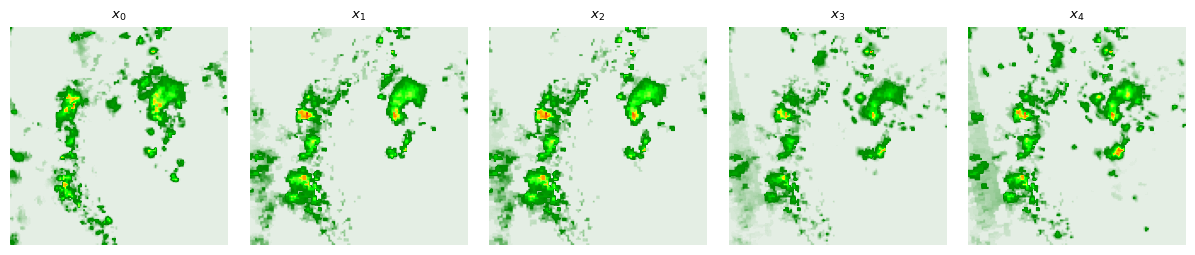

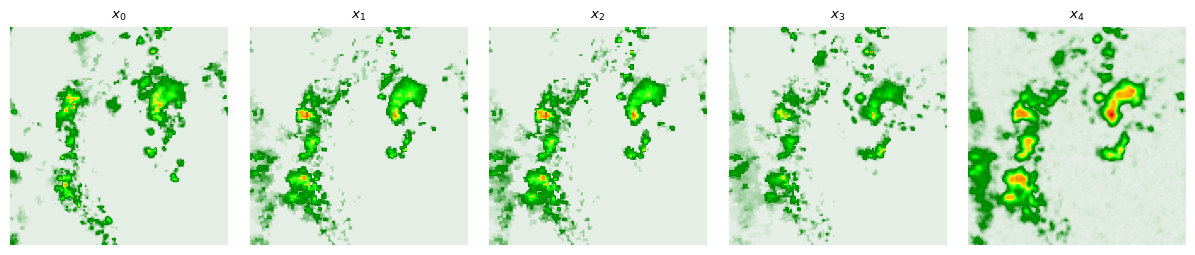

In [484]:
pysteps_model = PyStepsNowcastModel(
    input_precip_sequence=dummy_inputs[0, ...],
    input_dims=(1, 128, 128),  # c, h, w.
    horizon=30,  # in min
    data_time_interval=30,
    data_km_per_pixel_resolution=10,
    num_ensemble=10,
    transform_mm_h_to_dBR=True,
)

R_f = pysteps_model.nowcast(
    mm_h_precip_threshold=0.1,
    dBR_precip_threshold=-15,
    zero_value=-15,
    n_cascade_levels=6,
    noise_method="nonparametric",  # adds stochastic noise to represent growth/decay
    vel_pert_method="bps",  # If set to None, the advection field is not perturbed.
    mask_method="incremental",  # "sprog",
)

# plot nowcasts.
plot_a_sequence(
    X=torch.cat([dummy_inputs, dummy_target], dim=1),
    b=b,
    global_params=global_params,
    plot_params={"cmap": rain_cmap},
    layout_params=plt_params,
)
plot_a_sequence(
    X=torch.cat([dummy_inputs[b, ...], torch.from_numpy(R_f).mean(dim=0).unsqueeze(1)], dim=0).unsqueeze(
        0
    ),
    b=b,
    global_params=global_params,
    plot_params={"cmap": rain_cmap},
    layout_params=plt_params,
)

#### `create Predict dataloader`

In [485]:
datamodule.setup("predict")

predict_dataset = IMERGDataset(
    datamodule, "predict", sequence_length=INPUT_SEQUENCE_LENGTH, target_length=OUTPUT_SEQUENCE_LENGTH
)
predict_loader = DataLoader(
    dataset=predict_dataset, batch_size=6, num_workers=NUM_WORKERS, shuffle=False
)

[2024-11-24 16:21:40][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-11-24 16:21:40][imerg_precipitation.py][INFO] --> predict data split: [202303080000, 202303100000]
[2024-11-24 16:21:41][torch_datasets.py][INFO] --> creating PREDICT tensor dataset.
[2024-11-24 16:21:41][abstract_datamodule.py][INFO] -->  Dataset predict size: 11


#### `Eval predictions`

In [486]:
# ** create the eval dataloader **
eval_loader, _ = create_eval_loader(
    data_loader=predict_loader, horizon=8, input_sequence_length=4, img_dims=(128, 128)
)

** eval loader (INFO) **
Num samples = 11 w/ dims: torch.Size([12, 1, 128, 128])



In [498]:
.size()

torch.Size([3, 1, 128, 128])

In [488]:
# need to generate the horizon using STEPS.
# take in t

results = []
for e, (X, target) in enumerate(eval_loader):
    print(X.size(), target.size())
    predictions = {}
    # predict t+1

    for t in range(target.size(0)):
        # instantiate PySteps model using X.
        pysteps_model = PyStepsNowcastModel(
            input_precip_sequence=X,
            input_dims=(1, 128, 128),  # c, h, w.
            horizon=30,  # in min
            data_time_interval=30,
            data_km_per_pixel_resolution=10,
            num_ensemble=10,
            transform_mm_h_to_dBR=True,
        )

        # STEPS nowcast.
        R_f = pysteps_model.nowcast(
            mm_h_precip_threshold=0.1,
            dBR_precip_threshold=-15,
            zero_value=-15,
            n_cascade_levels=6,
            noise_method="nonparametric",  # adds stochastic noise to represent growth/decay.
            vel_pert_method="bps",  # If set to None, the advection field is not perturbed.
            mask_method="incremental",  # "sprog",
        )

        # get mean of ensemble.
        pred = np.mean(R_f, axis=0)

        # store the prediction.
        predictions[f"t{t+1}"] = pred

        # update the inputs with the last pred.
        X = torch.concat([X[1:, ...], pred.unsqueeze(0)], dim=1)














torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7
torch.Size([4, 1, 128, 128]) torch.Size([8, 1, 128, 128])
0
1
2
3
4
5
6
7


In [ ]:
results = []
with torch.no_grad():
    for e, (X, target) in enumerate(eval_loader):
        predictions = {}
        # predict t+1
        _input = X.clone().unsqueeze(0).to(device)

        for t in range(target.size(0)):
            pred = model(_input)
            if isinstance(model.output_activation, nn.Tanh):
                pred = transform_minus1_1_to_0_1(pred)

            predictions[f"t{t+1}"] = pred.squeeze(0)

            # update the inputs with the last pred.
            _input = torch.concat([_input[:, 1:, ...], pred], dim=1)

        results.append([target, predictions])